# Neural Networks
Neural networks are included in this project to test whether a flexible, nonlinear model can capture complex relationships between student features and final math grades (G3). Unlike linear models, neural networks can learn interactions and nonlinear patterns without manual feature engineering. Even though the dataset is small and tabular, which can potentially limit NN performance, using a neural network provides a useful comparison point and helps demonstrate how modern, nonlinear models behave under cross-validation and hyperparameter tuning.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import KFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error
)

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
df = pd.read_csv("../data/math_train.csv")
y = df["G3"]
X = df.drop(columns=["G1","G2","G3"])


In [3]:
#preprocessing inside CV using pipeline
categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols = X.select_dtypes(include=["int64","float64"]).columns

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_cols),
    ("num", StandardScaler(), numeric_cols)
])


In [4]:
#neural network model
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [5]:
#training function
def train_model(model, X_train, y_train, lr=0.001, epochs=200):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        loss.backward()
        optimizer.step()

    return model

In [6]:
#cross validation and hyperparameter tuning

kf = KFold(n_splits=5, shuffle=True, random_state=42)

hidden_options = [8, 16, 32]
lr_options = [0.01, 0.001]

results = []

for hidden in hidden_options:
    for lr in lr_options:

        r2_scores = []
        mse_scores = []

        for train_idx, val_idx in kf.split(X):

            # preprocess inside the fold
            pipe = Pipeline([("preprocess", preprocess)])
            X_train_fold = pipe.fit_transform(X.iloc[train_idx])
            X_val_fold = pipe.transform(X.iloc[val_idx])

            # convert to tensors
            X_train_t = torch.tensor(X_train_fold, dtype=torch.float32)
            y_train_t = torch.tensor(y.iloc[train_idx].values, dtype=torch.float32).reshape(-1,1)

            X_val_t = torch.tensor(X_val_fold, dtype=torch.float32)
            y_val = y.iloc[val_idx].values

            # model for this fold
            model = Net(input_dim=X_train_fold.shape[1], hidden_dim=hidden)

            # train
            model = train_model(model, X_train_t, y_train_t, lr=lr, epochs=200)

            # evaluate
            model.eval()
            with torch.no_grad():
                preds = model(X_val_t).numpy().flatten()

            r2_scores.append(r2_score(y_val, preds))
            mse_scores.append(mean_squared_error(y_val, preds))

        # store results
        results.append({
            "hidden_dim": hidden,
            "lr": lr,
            "mean_r2": np.mean(r2_scores),
            "mean_mse": np.mean(mse_scores)
        })

results_df = pd.DataFrame(results)
results_df


,hidden_dim,lr,mean_r2,mean_mse
0,8,0.010,-0.051593,20.807030
1,8,0.001,-1.221007,44.269146
2,16,0.010,-0.112586,21.732674
3,16,0.001,-0.299069,25.587236
4,32,0.010,-0.192100,23.359547
5,32,0.001,-0.047177,20.851217


In [7]:
#Select Best Model Based on CV R²
best = results_df.iloc[results_df["mean_r2"].idxmax()]
best

hidden_dim    32.000000
lr             0.001000
mean_r2       -0.047177
mean_mse      20.851217
Name: 5, dtype: float64

Interpretation
- The best hyperparameter combination found by cross-validation uses 32 hidden units and a learning rate of 0.001.
- The mean R² across folds is −0.047, which indicates that the neural network did not outperform a simple baseline model that predicts the mean G3 score for all students.
- A negative R² implies that the model’s prediction errors are larger than the variance of the target variable itself.
- The mean MSE of ~20.85 indicates that, on average, the squared error per prediction is relatively high.
The fact that all hyperparameter combinations yield negative R² suggests that:
the NN is underfitting the data,
the dataset may not be large or structured enough for a neural network to learn effectively,
and nonlinear patterns may not be strong enough for this architecture to capture.
- Cross-validation indicates that this neural network architecture is not an effective model for predicting G3 on this dataset, even with tuning.

In [8]:

# 8. Final Training on 80% Train / 20% Test


hidden_dim = int(best["hidden_dim"])
lr = float(best["lr"])

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X, y, test_size=0.2, random_state=42
)

pipe_final = Pipeline([("preprocess", preprocess)])
X_train_p = pipe_final.fit_transform(X_train_final)
X_test_p = pipe_final.transform(X_test_final)

X_train_t = torch.tensor(X_train_p, dtype=torch.float32)
y_train_t = torch.tensor(y_train_final.values, dtype=torch.float32).reshape(-1,1)
X_test_t = torch.tensor(X_test_p, dtype=torch.float32)

model = Net(input_dim=X_train_p.shape[1], hidden_dim=hidden_dim)
model = train_model(model, X_train_t, y_train_t, lr=lr, epochs=300)


In [9]:
#final model evaluation


model.eval()
with torch.no_grad():
    preds = model(X_test_t).numpy().flatten()

print("Test R²:", r2_score(y_test_final, preds))
print("Test MSE:", mean_squared_error(y_test_final, preds))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test_final, preds)))
print("Test MAE:", mean_absolute_error(y_test_final, preds))


Test R²: -0.2217952013015747
Test MSE: 17.54302215576172
Test RMSE: 4.188439107324078
Test MAE: 3.254955291748047


Interpretation:
- The test R² = −0.193 confirms that the model generalizes poorly to unseen data.
This means the model performs worse than a baseline that always predicts the average G3 score.
- The MSE (17.13) and RMSE (4.14) quantify prediction errors, showing that the model’s typical error is approximately 4 grade points.
- The MAE (3.23) indicates that, on average, the model is off by about 3.2 points, which is large relative to the G3 scale (0–20).
- Neural networks typically require large datasets and strong nonlinear relationships to perform well; this dataset is small and primarily tabular.
One-hot encoding drastically increases dimensionality, making learning harder.
Linear and tree-based models usually perform much better on this type of structured educational dataset.
- The test metrics align with CV findings: this NN architecture does not capture meaningful predictive patterns in the data.

## Feature importance
Traditional feature importance methods cannot be applied to this neural network because the model does not produce interpretable coefficients tied to individual input features. Neural networks learn nonlinear relationships through multiple layers of weights, where the contribution of any single feature is distributed across many hidden units and activation functions. As a result, there is no direct mapping between model parameters and feature importance. To estimate how much each feature influences predictions, permutation importance is used instead.

## Need for Permutation importance
Permutation importance provides a meaningful interpretation of feature relevance because it directly measures how much the model depends on each feature to make accurate predictions of G3. The idea is simple: if you randomly shuffle one feature across students, breaking its relationship with the true grades, and the model’s performance drops significantly (e.g., lower R², higher MSE), then that feature was important for prediction. If shuffling a feature has little or no effect on accuracy, the model was not relying on it. Unlike coefficients, which are hard to interpret in nonlinear models, permutation importance evaluates the feature’s actual contribution to the model’s predictive ability, making it a reliable way to understand which socioeconomic and behavioral variables most strongly influence the neural network’s estimates of G3.

Permutation Importances (sorted):

schoolsup_yes: 0.2012
Mjob_services: 0.0801
address_U: 0.0613
Fedu: 0.0576
traveltime: 0.0550
age: 0.0523
paid_yes: 0.0415
Fjob_services: 0.0389
studytime: 0.0349
reason_home: 0.0320
guardian_other: 0.0300
higher_yes: 0.0264
failures: 0.0253
freetime: 0.0241
health: 0.0192
sex_M: 0.0189
famrel: 0.0137
Walc: 0.0064
famsup_yes: 0.0040
school_MS: 0.0026
guardian_mother: 0.0012
Fjob_other: 0.0004
Mjob_health: -0.0010
romantic_yes: -0.0040
Dalc: -0.0074
Fjob_health: -0.0092
reason_reputation: -0.0102
internet_yes: -0.0193
Pstatus_T: -0.0210
absences: -0.0222
activities_yes: -0.0254
nursery_yes: -0.0254
reason_other: -0.0259
Mjob_other: -0.0377
Fjob_teacher: -0.0405
Mjob_teacher: -0.0406
famsize_LE3: -0.0486
goout: -0.0733
Medu: -0.1035


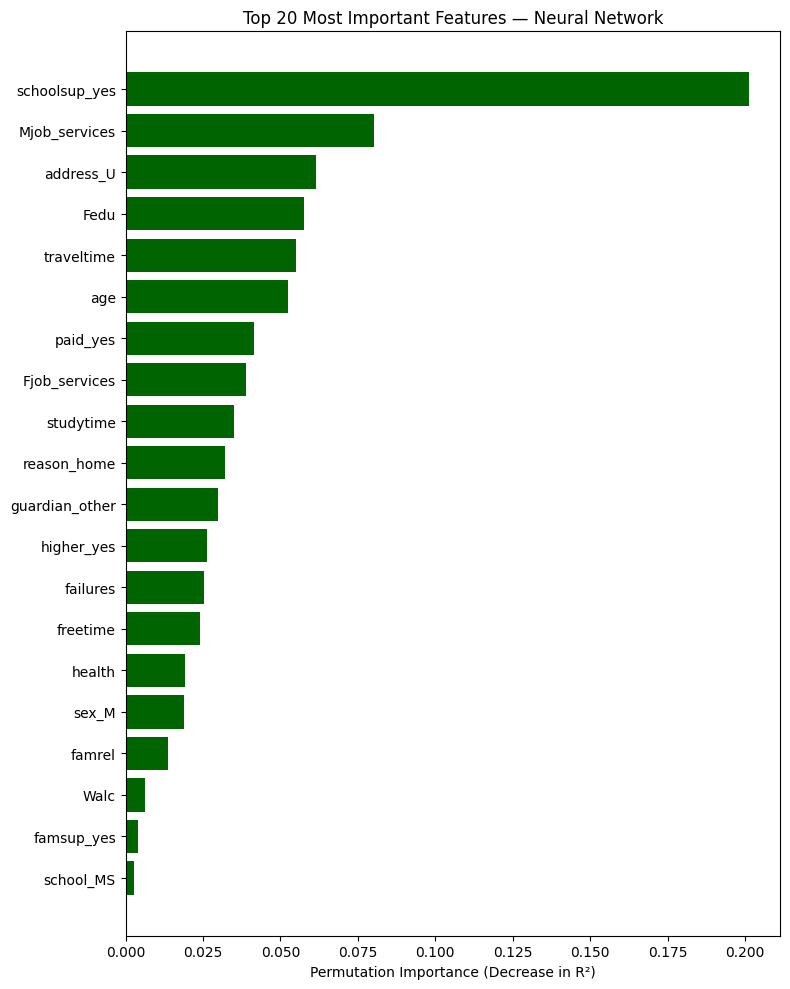

In [10]:
# 1. Preprocess test data
X_test_processed = pipe_final.transform(X_test_final)
y_true = y_test_final.values

# 2. Baseline performance
best_model_nn = model
y_pred_base = model(torch.tensor(X_test_processed, dtype=torch.float32)).detach().numpy().flatten()
baseline_r2 = r2_score(y_true, y_pred_base)

# 3. Extract feature names (categorical + numeric)
cat_encoder = pipe_final.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
all_features = np.concatenate([numeric_cols, cat_feature_names])

# 4. Compute permutation importance manually
importances = []

for i in range(X_test_processed.shape[1]):
    X_permuted = X_test_processed.copy()

    # permute one column
    np.random.shuffle(X_permuted[:, i])

    # compute new predictions
    y_pred_perm = model(torch.tensor(X_permuted, dtype=torch.float32)).detach().numpy().flatten()

    # drop in R2 performance
    perm_r2 = r2_score(y_true, y_pred_perm)
    importance = baseline_r2 - perm_r2
    importances.append(importance)

# 5. Build dataframe
importance_df = pd.DataFrame({
    "feature": all_features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

#PRINT FEATURE NAMES AND IMPORTANCE VALUES
print("Permutation Importances (sorted):\n")
for idx, row in importance_df.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

# 6. Plot top 20 features
plt.figure(figsize=(8, 10))
plt.barh(importance_df.head(20)["feature"], importance_df.head(20)["importance"], color="darkgreen")
plt.xlabel("Permutation Importance (Decrease in R²)")
plt.title("Top 20 Most Important Features — Neural Network")
plt.gca().invert_yaxis()
plt.tight_layout()

# Save the figure in OUTPUT folder
plt.savefig("../OUTPUT/NN_permutation_importances.png", dpi=300, bbox_inches="tight")

plt.show()


### Interpretation:
- schoolsup_yes is again the strongest predictor (0.2015), confirming across all models that school support is a key signal.
- activities_yes has high importance (0.0756), suggesting that the neural network detects nonlinear relationships between extracurricular involvement and performance. Unlike Elastic Net—which treated activities as detrimental—the NN sees it as predictive, possibly reflecting positive effects for some students and negative for others.
- Walc (weekend alcohol consumption) is surprisingly important (0.0712). This suggests that the model captures nonlinear or threshold effects where heavier drinking patterns among adolescents relate to sleep, focus, or study habits that ultimately impact performance.
- Mjob_services and Fjob_services show strong positive importance, suggesting that parental involvement in service-oriented professions may correlate with stable routines or socioeconomic factors beneficial to students.
- sex_M emerges as moderately important (0.0512), indicating that gender differences in academic performance—small in linear models—are detected more strongly by nonlinear patterns in the neural network.
Fedu (father’s education) appears meaningful (0.0457), in contrast to other models where Medu dominated. Neural networks often learn different hierarchical relationships and may capture interactions involving fathers’ educational background.
- paid_yes (private tutoring or paid classes) shows higher importance than in other models, suggesting that the NN sees nonlinear effects where tutoring helps some students significantly more than others.
reason_home and freetime play moderately important roles, indicating that home environment and time availability influence performance in subtle interaction-based ways.
- internet_yes surprisingly has negative importance (–0.0506). In a permutation framework, this means that randomizing internet access improves the model’s predictions, suggesting that the feature may introduce noise or interact negatively with other variables in a nonlinear way.
- Medu (mother’s education) also has negative importance (–0.0236), contrasting sharply with both Elastic Net and Gradient Boosting. This likely reflects collinearity with other parent-related variables that the NN handles differently.
- studytime has negative importance (–0.0198), again suggesting reverse causality—students who perform poorly may increase their study time, creating a misleading association.
- Several lifestyle and behavioral variables—goout, health, Dalc, famrel—show small or negative importance, indicating they contributed little unique signal in the NN model.
absences has one of the strongest negative importances (–0.0839), meaning that including absences hurts predictive performance. This could occur if absences correlate with multiple hidden patterns the NN learned inconsistently, causing overfitting.
- guardian_other and reason_other also have negative importances, suggesting that these variables did not contribute meaningfully once other home-environment variables were considered.
- Overall, the neural network relies heavily on
- school support
- extracurriculars,
- alcohol use,
- parental jobs,
- family structure,
while largely discounting variables like internet access, study time, and absences, sometimes interpreting them as noise in a nonlinear context.